In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pdp
import matplotlib as mpl
mpl.rcParams['font.size'] = 15.0
%matplotlib inline
import imp
plt.style.use('seaborn-darkgrid')
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from numpy.linalg import svd
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, NMF
from os import listdir
import warnings
from xgboost import XGBRFClassifier
import tensorflow as tf
warnings.filterwarnings('ignore')
import ast

In [3]:
import src.LC_Clean_Assist as LCC
import src.LC_Plotter as LCP
import src.LC_Transformer as LCT
import src.LC_Models as LCM
imp.reload(LCP)
imp.reload(LCC)
imp.reload(LCT)
imp.reload(LCM)

<module 'src.LC_Models' from '/Users/adamricks/Documents/Galvanize/Capstones/LendingClub/lending-club/src/LC_Models.py'>

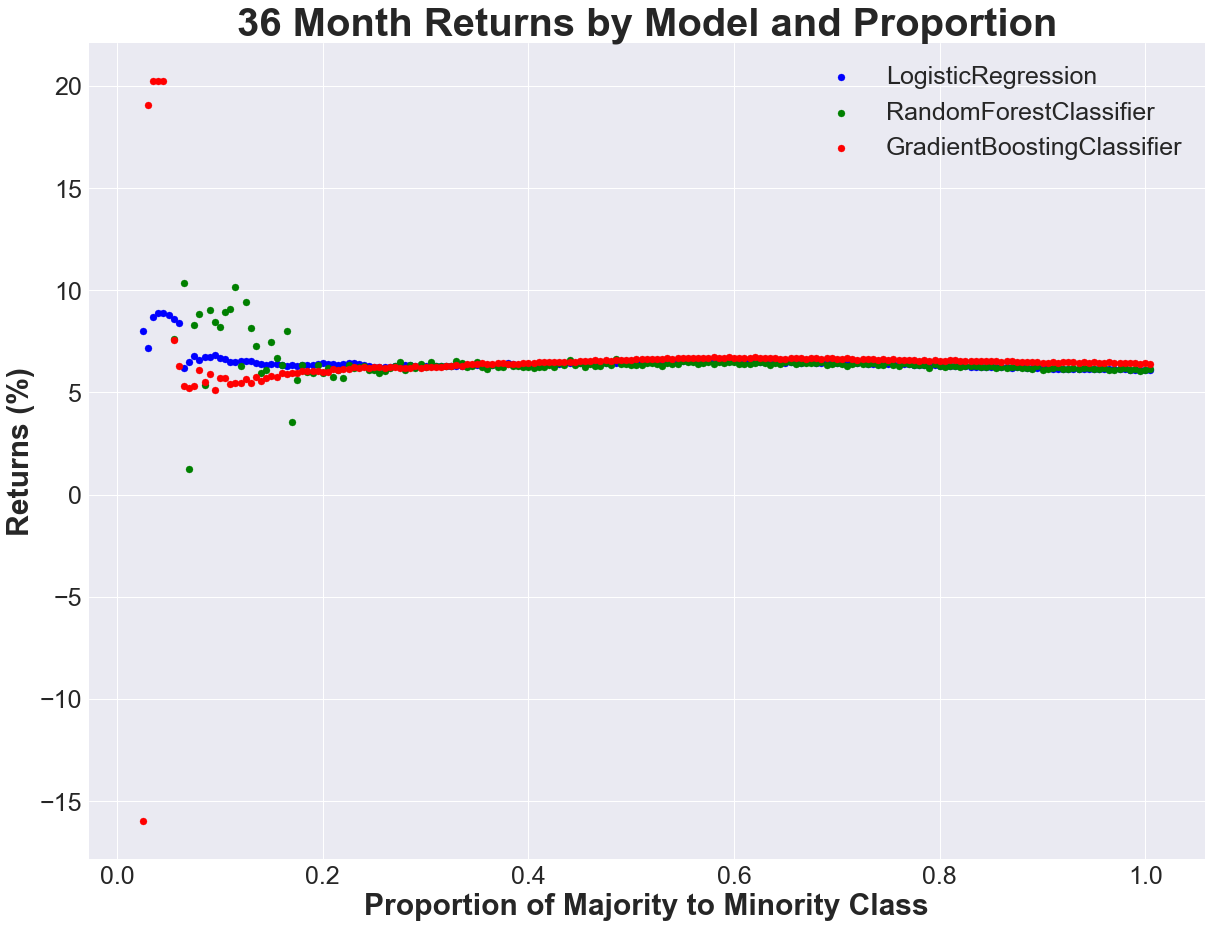

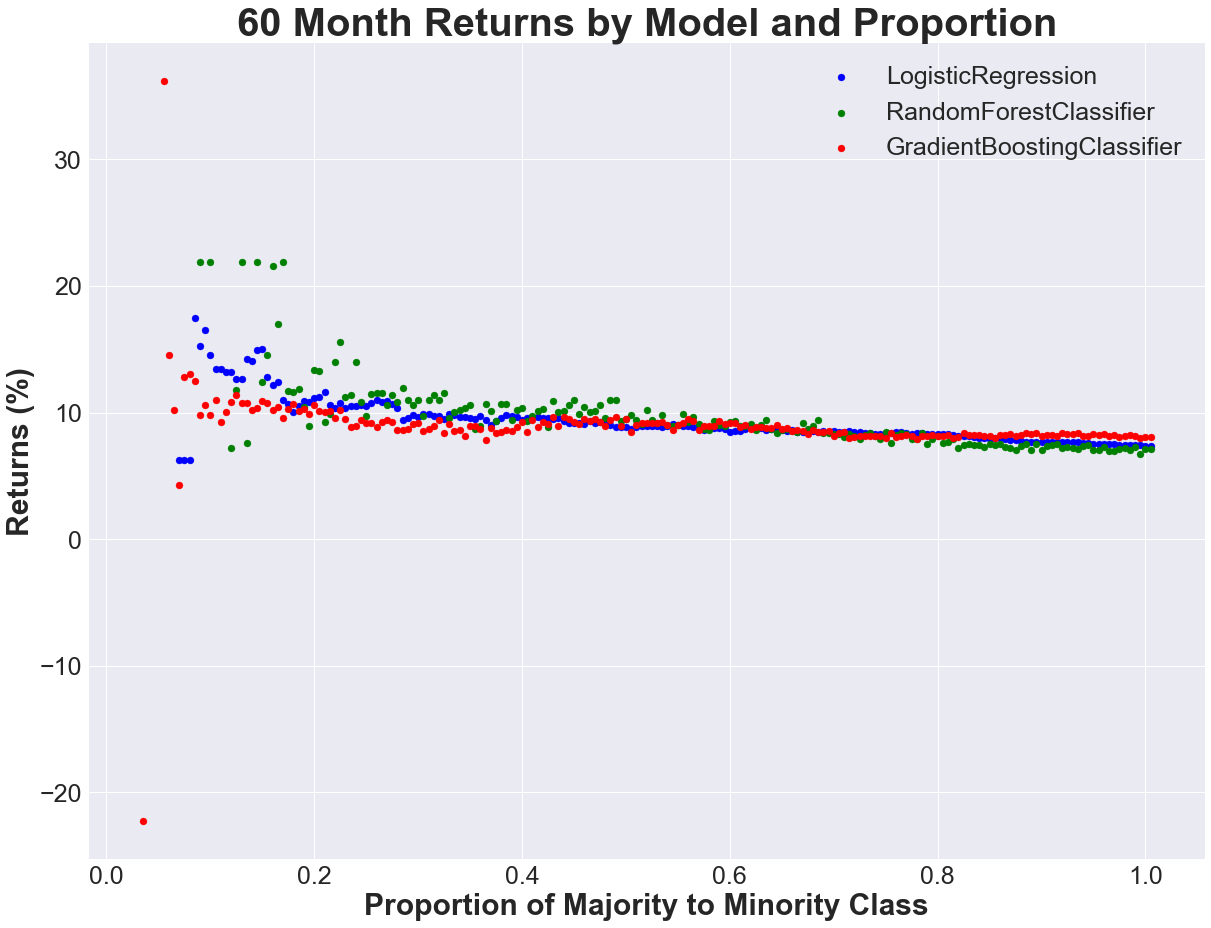

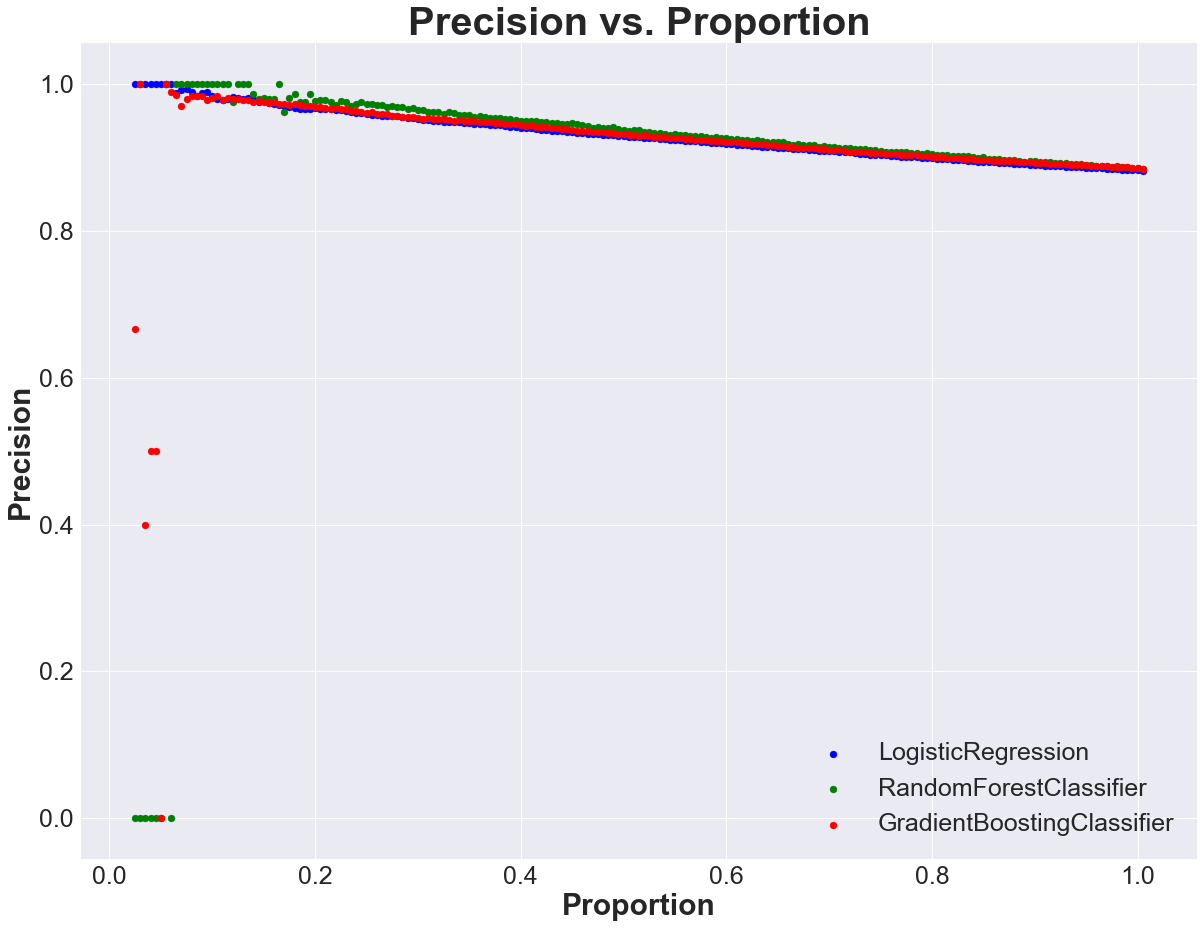

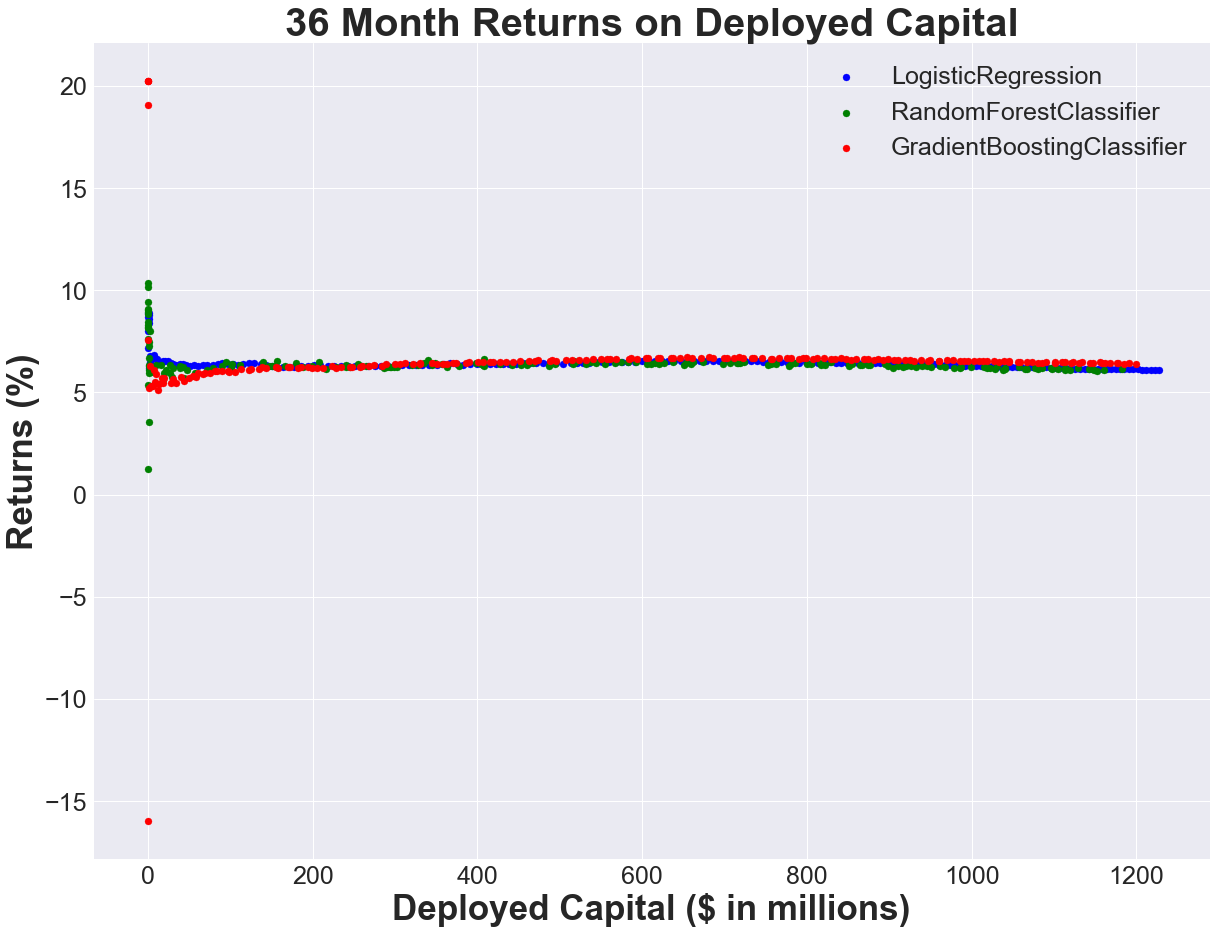

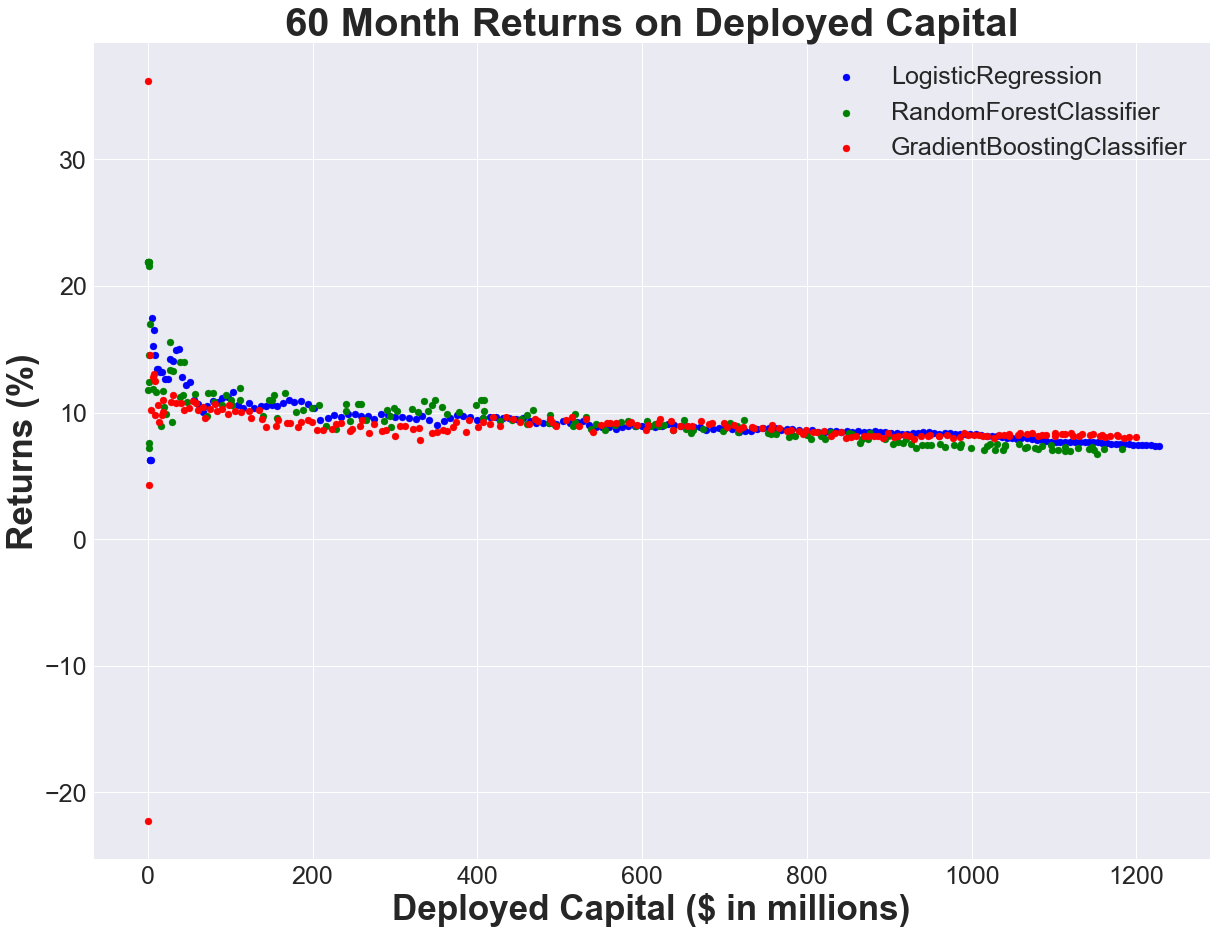

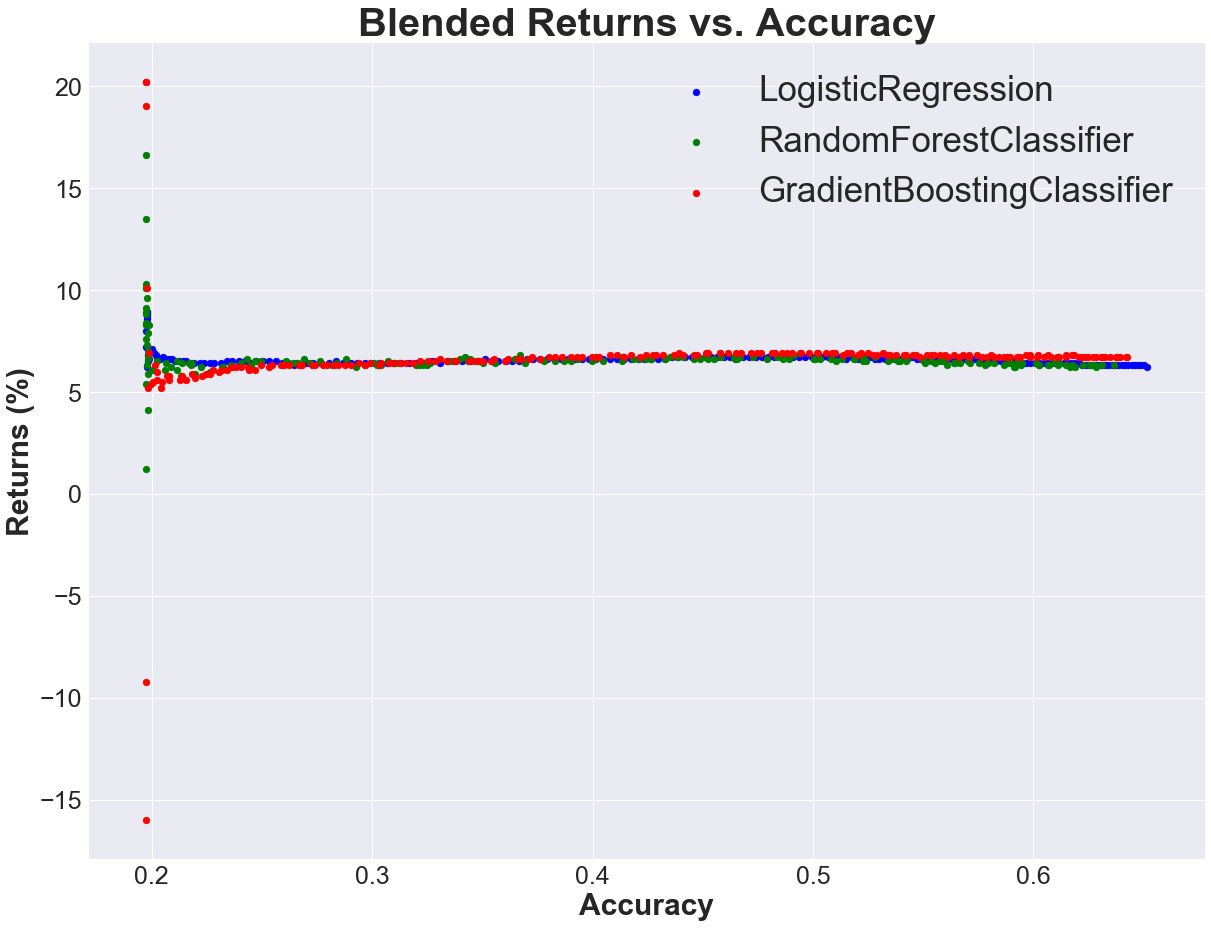

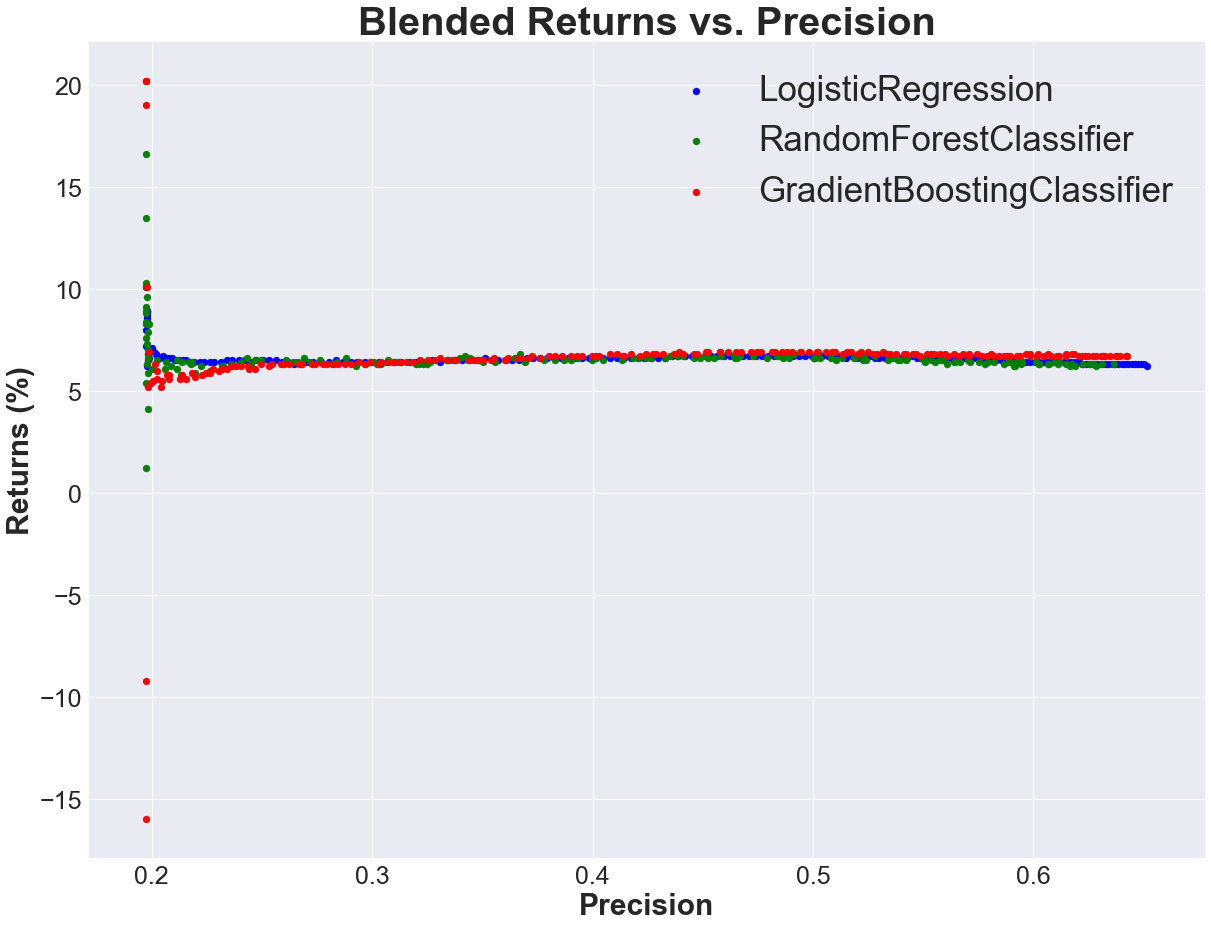

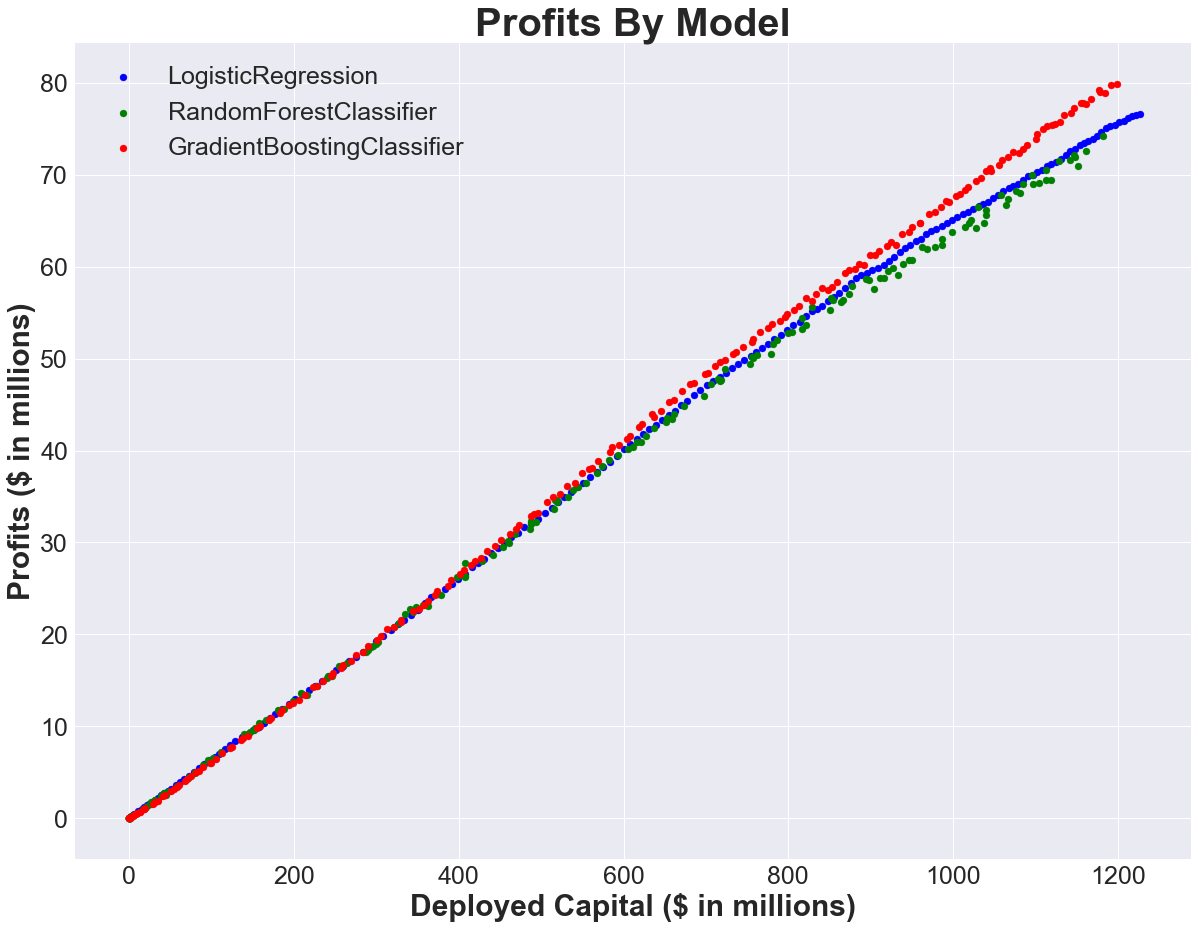

In [62]:
logm_optimized = pd.read_csv('models/logm_optimized.csv')
rfc_optimized = pd.read_csv('models/rfc_optimized.csv')
gbc_df = pd.read_csv('models/gbc_optimized.csv')
combined = pd.concat([logm_optimized,rfc_optimized,gbc_df])
imp.reload(LCP)
LCP.plot_36m_returns(combined)
LCP.plot_60m_returns(combined)
LCP.plot_prec_by_prop(combined)
LCP.plot_36m_deployed(combined)
LCP.plot_60m_deployed(combined)
LCP.plot_rets_v_acc(combined)
LCP.plot_rets_v_prec(combined)
LCP.profits_v_deployed(combined)

In [89]:
combined.columns

Index(['Proportions', 'Returns', 'Profits', 'Accuracy', 'Precision',
       'Best_Params', 'Deployed_Capital', 'Returned_Capital',
       '36 Month Returns', '36 Month Deployed Capital',
       '36 Month Returned Capital', '60 Month Returns',
       '60 Month Deployed Capital', '60 Month Returned Capital', 'model'],
      dtype='object')

In [92]:
combined.sort_values(by='Returns',ascending=False)[['model','Returns','Proportions','Deployed_Capital']].head(3)

,model,Returns,Proportions,Deployed_Capital
4,GradientBoostingClassifier,20.2,0.045,24800.0
3,GradientBoostingClassifier,20.2,0.040,24800.0
1,GradientBoostingClassifier,19.0,0.030,36000.0


In [93]:
combined.sort_values(by='36 Month Returns',ascending=False)[['model','36 Month Returns','Proportions','36 Month Deployed Capital']].head(3)


,model,36 Month Returns,Proportions,36 Month Deployed Capital
4,GradientBoostingClassifier,20.22,0.045,24800.0
3,GradientBoostingClassifier,20.22,0.040,24800.0
2,GradientBoostingClassifier,20.22,0.035,24800.0


In [94]:
combined.sort_values(by='60 Month Returns',ascending=False)[['model','60 Month Returns','Proportions','60 Month Deployed Capital']].head(3)



,model,60 Month Returns,Proportions,60 Month Deployed Capital
6,GradientBoostingClassifier,36.15,0.055,23125.0
21,RandomForestClassifier,21.92,0.130,40000.0
29,RandomForestClassifier,21.92,0.170,40000.0


In [6]:
sharpe_matrix = LCT.get_compiled_models(combined)

In [7]:
imp.reload(LCM)
df_opt = pd.read_csv('models/sharpe_optimized.csv')
df_r = pd.read_csv('models/sharpe_large_deployed.csv')

In [8]:
df = pd.concat([df_opt,df_r])

In [9]:
df_sharpe = LCM.sharpe_calc_df(df)

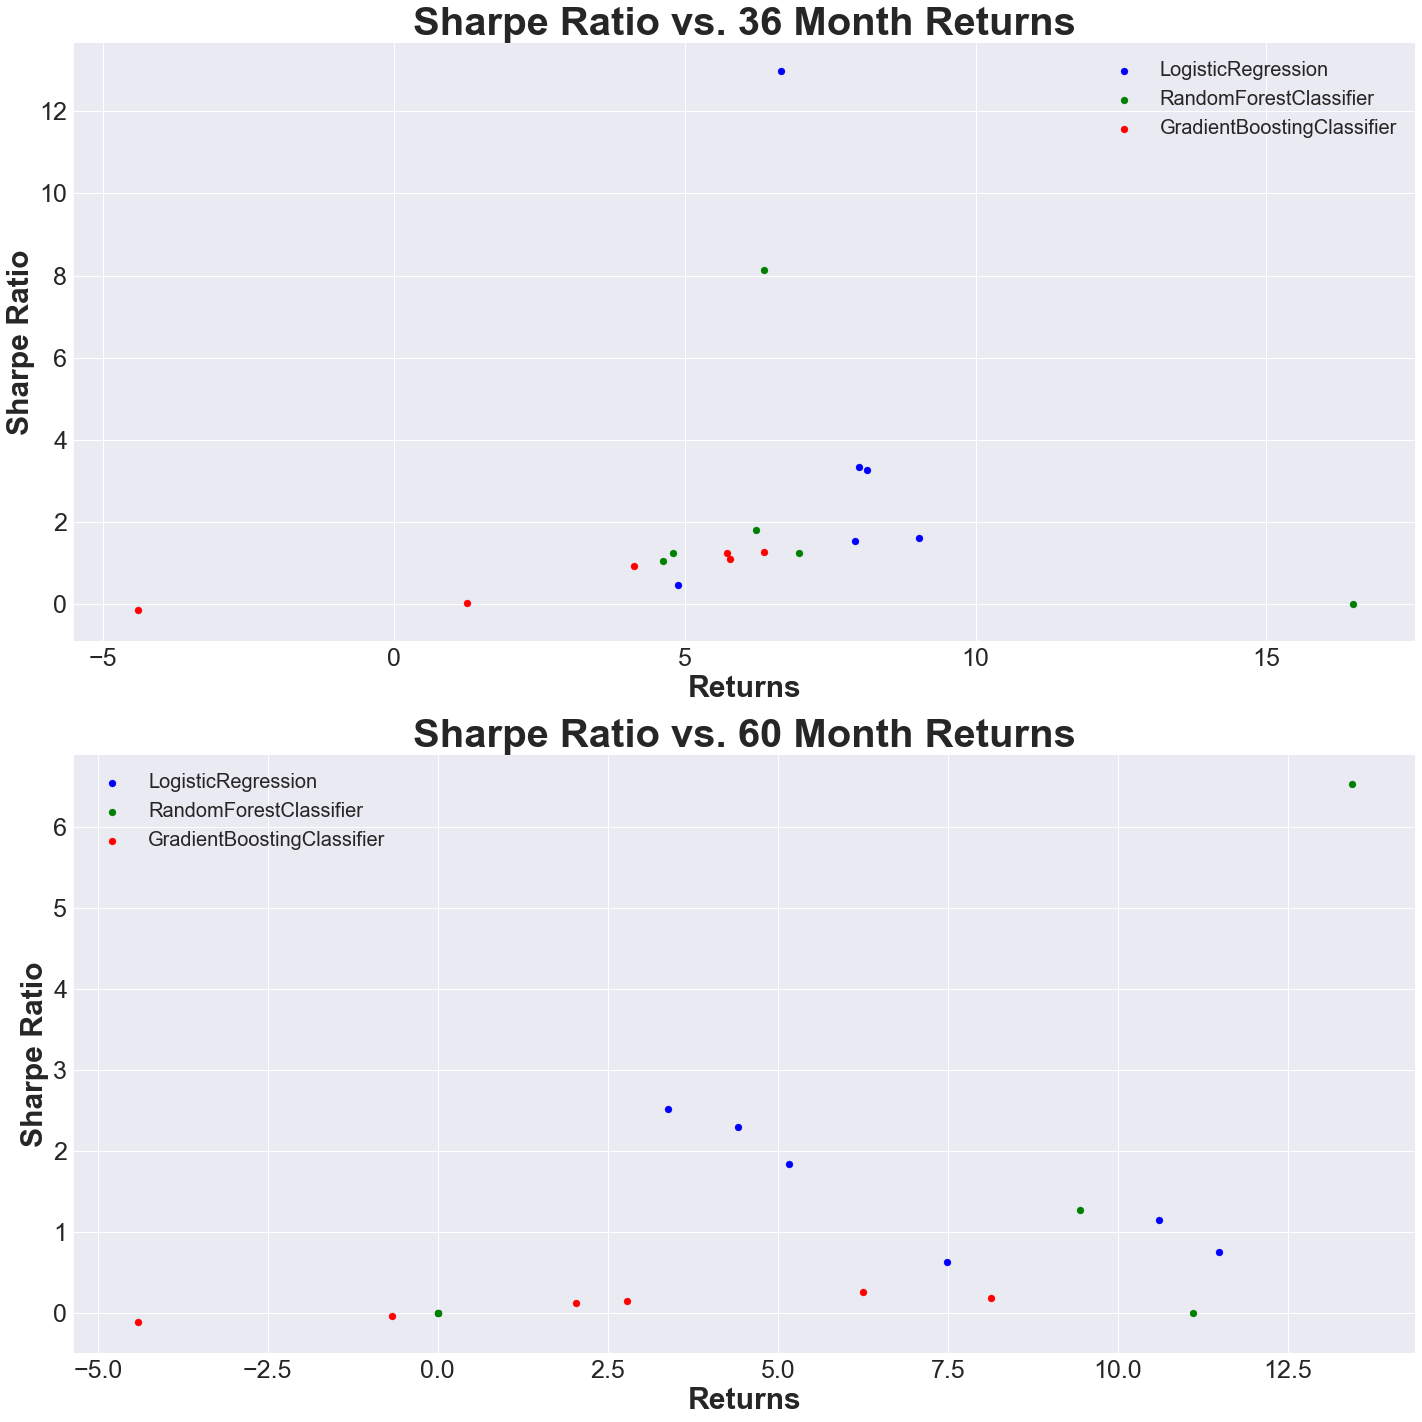

In [76]:
imp.reload(LCP)
LCP.plot_sharpe(df)

In [11]:
df_sharpe[df_sharpe['Sharpe_60'] == df['Sharpe_60'].max()]

,Model_list,Proportions,Parameters,Return_List,Return36_List,Return60_List,Deployed_Capital,Deployed_Capital_36,Deployed_Capital_60,Avg_Return,Avg_Return_36,Avg_Return_60,Sharpe_Overall,Sharpe_36,Sharpe_60,Avg_Deployed_36,Avg_Deployed_60,Model
3,RandomForestClassifier___best,0.09,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...","[11.4252, 14.7023, 11.3686, -2.8946, 5.2355, 6...","[11.4252, 14.7023, 11.3686, -6.0667, 5.2355, 6...","[15.5041, 11.3867]","[181000.0, 35000.0, 28000.0, 238000.0, 18700.0...","[181000.0, 35000.0, 28000.0, 203000.0, 18700.0...","[35000.0, 18000.0]",7.555573,6.970727,13.4454,1.648712,1.260272,6.531015,0.076161,0.0265,RandomForestClassifier


In [12]:
df_sharpe[df_sharpe['Sharpe_36'] == df['Sharpe_36'].max()]

,Model_list,Proportions,Parameters,Return_List,Return36_List,Return60_List,Deployed_Capital,Deployed_Capital_36,Deployed_Capital_60,Avg_Return,Avg_Return_36,Avg_Return_60,Sharpe_Overall,Sharpe_36,Sharpe_60,Avg_Deployed_36,Avg_Deployed_60,Model
2,LogisticRegression___60m,0.085,"{'C': 0.05, 'penalty': 'l1'}","[6.3833, 7.2216, 6.7383, 6.9495, 6.5433, 6.647...","[6.1367, 6.9325, 6.752, 6.7957, 6.3257, 6.5585...","[15.1613, 17.5624, 6.2258, 13.7354, 36.2072, 1...","[3439450.0, 3934750.0, 3758125.0, 3926300.0, 4...","[3345450.0, 3827750.0, 3660125.0, 3839300.0, 4...","[94000.0, 107000.0, 98000.0, 87000.0, 35000.0,...",6.649878,6.660438,7.491579,12.596831,12.979639,0.631191,3.953119,0.074771,LogisticRegression


In [78]:
print(df_sharpe[df_sharpe['Sharpe_60'] == df['Sharpe_60'].max()]['Parameters'].values)
print(df_sharpe[df_sharpe['Sharpe_36'] == df['Sharpe_36'].max()]['Parameters'].values)

["{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}"]
["{'C': 0.05, 'penalty': 'l1'}"]


In [13]:
df_sharpe.shape

(18, 18)

Models to Use:
-  36M Loans: Logistic Regression, p = 0.085
-  60M Loans: Random Forest, p = 0.09

In [14]:
pca_df = pd.read_csv('data/pca_df.csv')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(pca_df.iloc[:,:-1], pca_df.iloc[:,-1], test_size=0.1)

In [16]:
imp.reload(LCM)
p1 = 0.085
p2 = 0.09
mod_36m_params = ast.literal_eval(df_sharpe[df_sharpe['Sharpe_36'] == df['Sharpe_36'].max()]['Parameters'].values[0])
mod_60m_params = ast.literal_eval(df_sharpe[df_sharpe['Sharpe_60'] == df['Sharpe_60'].max()]['Parameters'].values[0])
logr = LogisticRegression(**mod_36m_params)
rfc = RandomForestClassifier(**mod_60m_params)
rets = []
rets_36 = []
rets_60 = []
deployed = []
deployed_36 = []
deployed_60 = []
for j in range(1000):
    print('Running Iteration: {}'.format(j+1))
    overall_return, deployed_capital, returned_capital, t_36_rets,t_36_deployed,t_36_pl,t_60_rets,t_60_deployed,t_60_pl = LCM.final_system(pca_df,logr,rfc,p1,p2)
    rets.append(overall_return)
    rets_36.append(t_36_rets)
    rets_60.append(t_60_rets)
    deployed.append(deployed_capital)
    deployed_36.append(t_36_deployed)
    deployed_60.append(t_60_deployed)

Running Iteration: 1
Running Iteration: 2
Running Iteration: 3
Running Iteration: 4
Running Iteration: 5
Running Iteration: 6
Running Iteration: 7
Running Iteration: 8
Running Iteration: 9
Running Iteration: 10
Running Iteration: 11
Running Iteration: 12
Running Iteration: 13
Running Iteration: 14
Running Iteration: 15
Running Iteration: 16
Running Iteration: 17
Running Iteration: 18
Running Iteration: 19
Running Iteration: 20
Running Iteration: 21
Running Iteration: 22
Running Iteration: 23
Running Iteration: 24
Running Iteration: 25
Running Iteration: 26
Running Iteration: 27
Running Iteration: 28
Running Iteration: 29
Running Iteration: 30
Running Iteration: 31
Running Iteration: 32
Running Iteration: 33
Running Iteration: 34
Running Iteration: 35
Running Iteration: 36
Running Iteration: 37
Running Iteration: 38
Running Iteration: 39
Running Iteration: 40
Running Iteration: 41
Running Iteration: 42
Running Iteration: 43
Running Iteration: 44
Running Iteration: 45
Running Iteration: 

Running Iteration: 362
Running Iteration: 363
Running Iteration: 364
Running Iteration: 365
Running Iteration: 366
Running Iteration: 367
Running Iteration: 368
Running Iteration: 369
Running Iteration: 370
Running Iteration: 371
Running Iteration: 372
Running Iteration: 373
Running Iteration: 374
Running Iteration: 375
Running Iteration: 376
Running Iteration: 377
Running Iteration: 378
Running Iteration: 379
Running Iteration: 380
Running Iteration: 381
Running Iteration: 382
Running Iteration: 383
Running Iteration: 384
Running Iteration: 385
Running Iteration: 386
Running Iteration: 387
Running Iteration: 388
Running Iteration: 389
Running Iteration: 390
Running Iteration: 391
Running Iteration: 392
Running Iteration: 393
Running Iteration: 394
Running Iteration: 395
Running Iteration: 396
Running Iteration: 397
Running Iteration: 398
Running Iteration: 399
Running Iteration: 400
Running Iteration: 401
Running Iteration: 402
Running Iteration: 403
Running Iteration: 404
Running Ite

Running Iteration: 719
Running Iteration: 720
Running Iteration: 721
Running Iteration: 722
Running Iteration: 723
Running Iteration: 724
Running Iteration: 725
Running Iteration: 726
Running Iteration: 727
Running Iteration: 728
Running Iteration: 729
Running Iteration: 730
Running Iteration: 731
Running Iteration: 732
Running Iteration: 733
Running Iteration: 734
Running Iteration: 735
Running Iteration: 736
Running Iteration: 737
Running Iteration: 738
Running Iteration: 739
Running Iteration: 740
Running Iteration: 741
Running Iteration: 742
Running Iteration: 743
Running Iteration: 744
Running Iteration: 745
Running Iteration: 746
Running Iteration: 747
Running Iteration: 748
Running Iteration: 749
Running Iteration: 750
Running Iteration: 751
Running Iteration: 752
Running Iteration: 753
Running Iteration: 754
Running Iteration: 755
Running Iteration: 756
Running Iteration: 757
Running Iteration: 758
Running Iteration: 759
Running Iteration: 760
Running Iteration: 761
Running Ite

In [19]:
dat = {'System_Returns':rets,'System_Returns_36':rets_36,'System_Returns_60':rets_60,
      'Deployed':deployed,'Deployed_36':deployed_36,'Deployed_60':deployed_60}
system_data = pd.DataFrame(dat)
system_data.to_csv('models/system_data.csv',index=False)

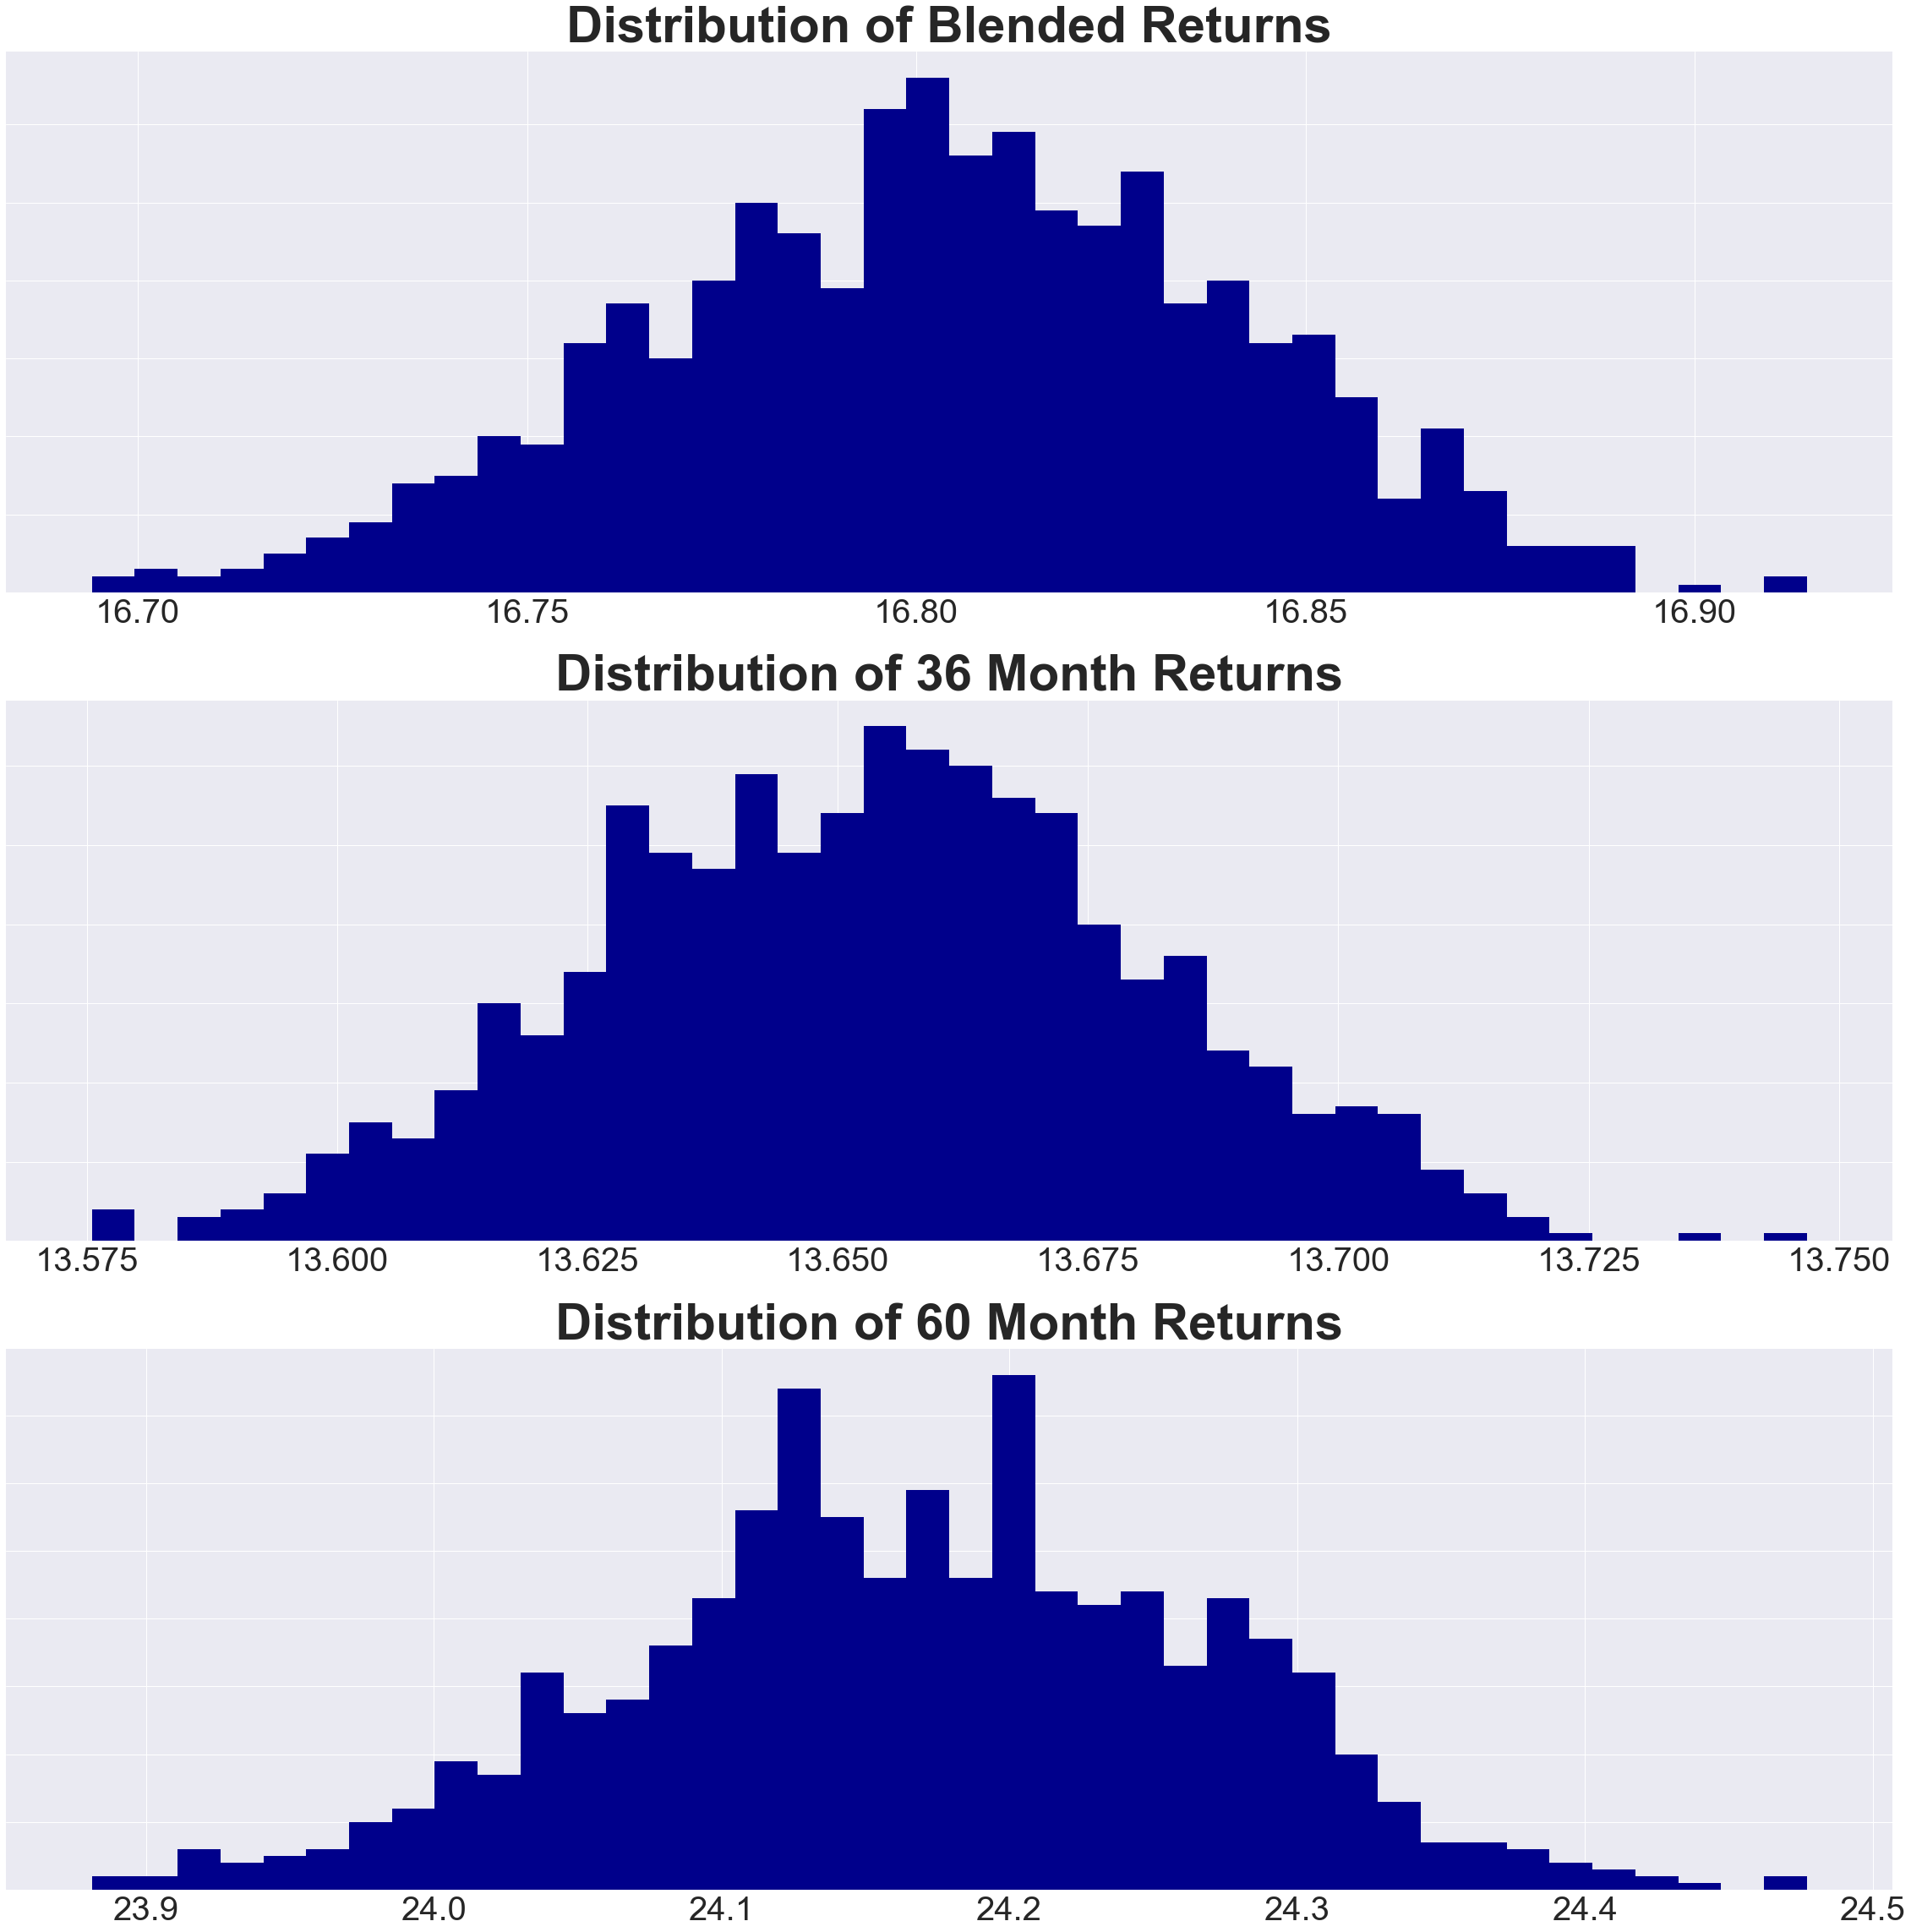

In [51]:
fig = plt.figure(figsize = (40,40))
ax1 = fig.add_subplot(3,1,1)
ax1.hist(rets,color='darkblue',bins=40)
ax1.tick_params('x',labelsize=40)
ax1.set_yticklabels([])
plt.title('Distribution of Blended Returns',fontsize=60,fontweight='bold')
ax2 = fig.add_subplot(3,1,2)
ax2.hist(rets_36,color='darkblue',bins=40)
ax2.tick_params('x',labelsize=40)
ax2.set_yticklabels([])
plt.title('Distribution of 36 Month Returns',fontsize=60,fontweight='bold')
ax3 = fig.add_subplot(3,1,3)
ax3.hist(rets_60,color='darkblue',bins=40)
ax3.tick_params('x',labelsize=40)
ax3.set_yticklabels([])
plt.title('Distribution of 60 Month Returns',fontsize=60,fontweight='bold')
plt.savefig('images/system_returns_distributions.png');

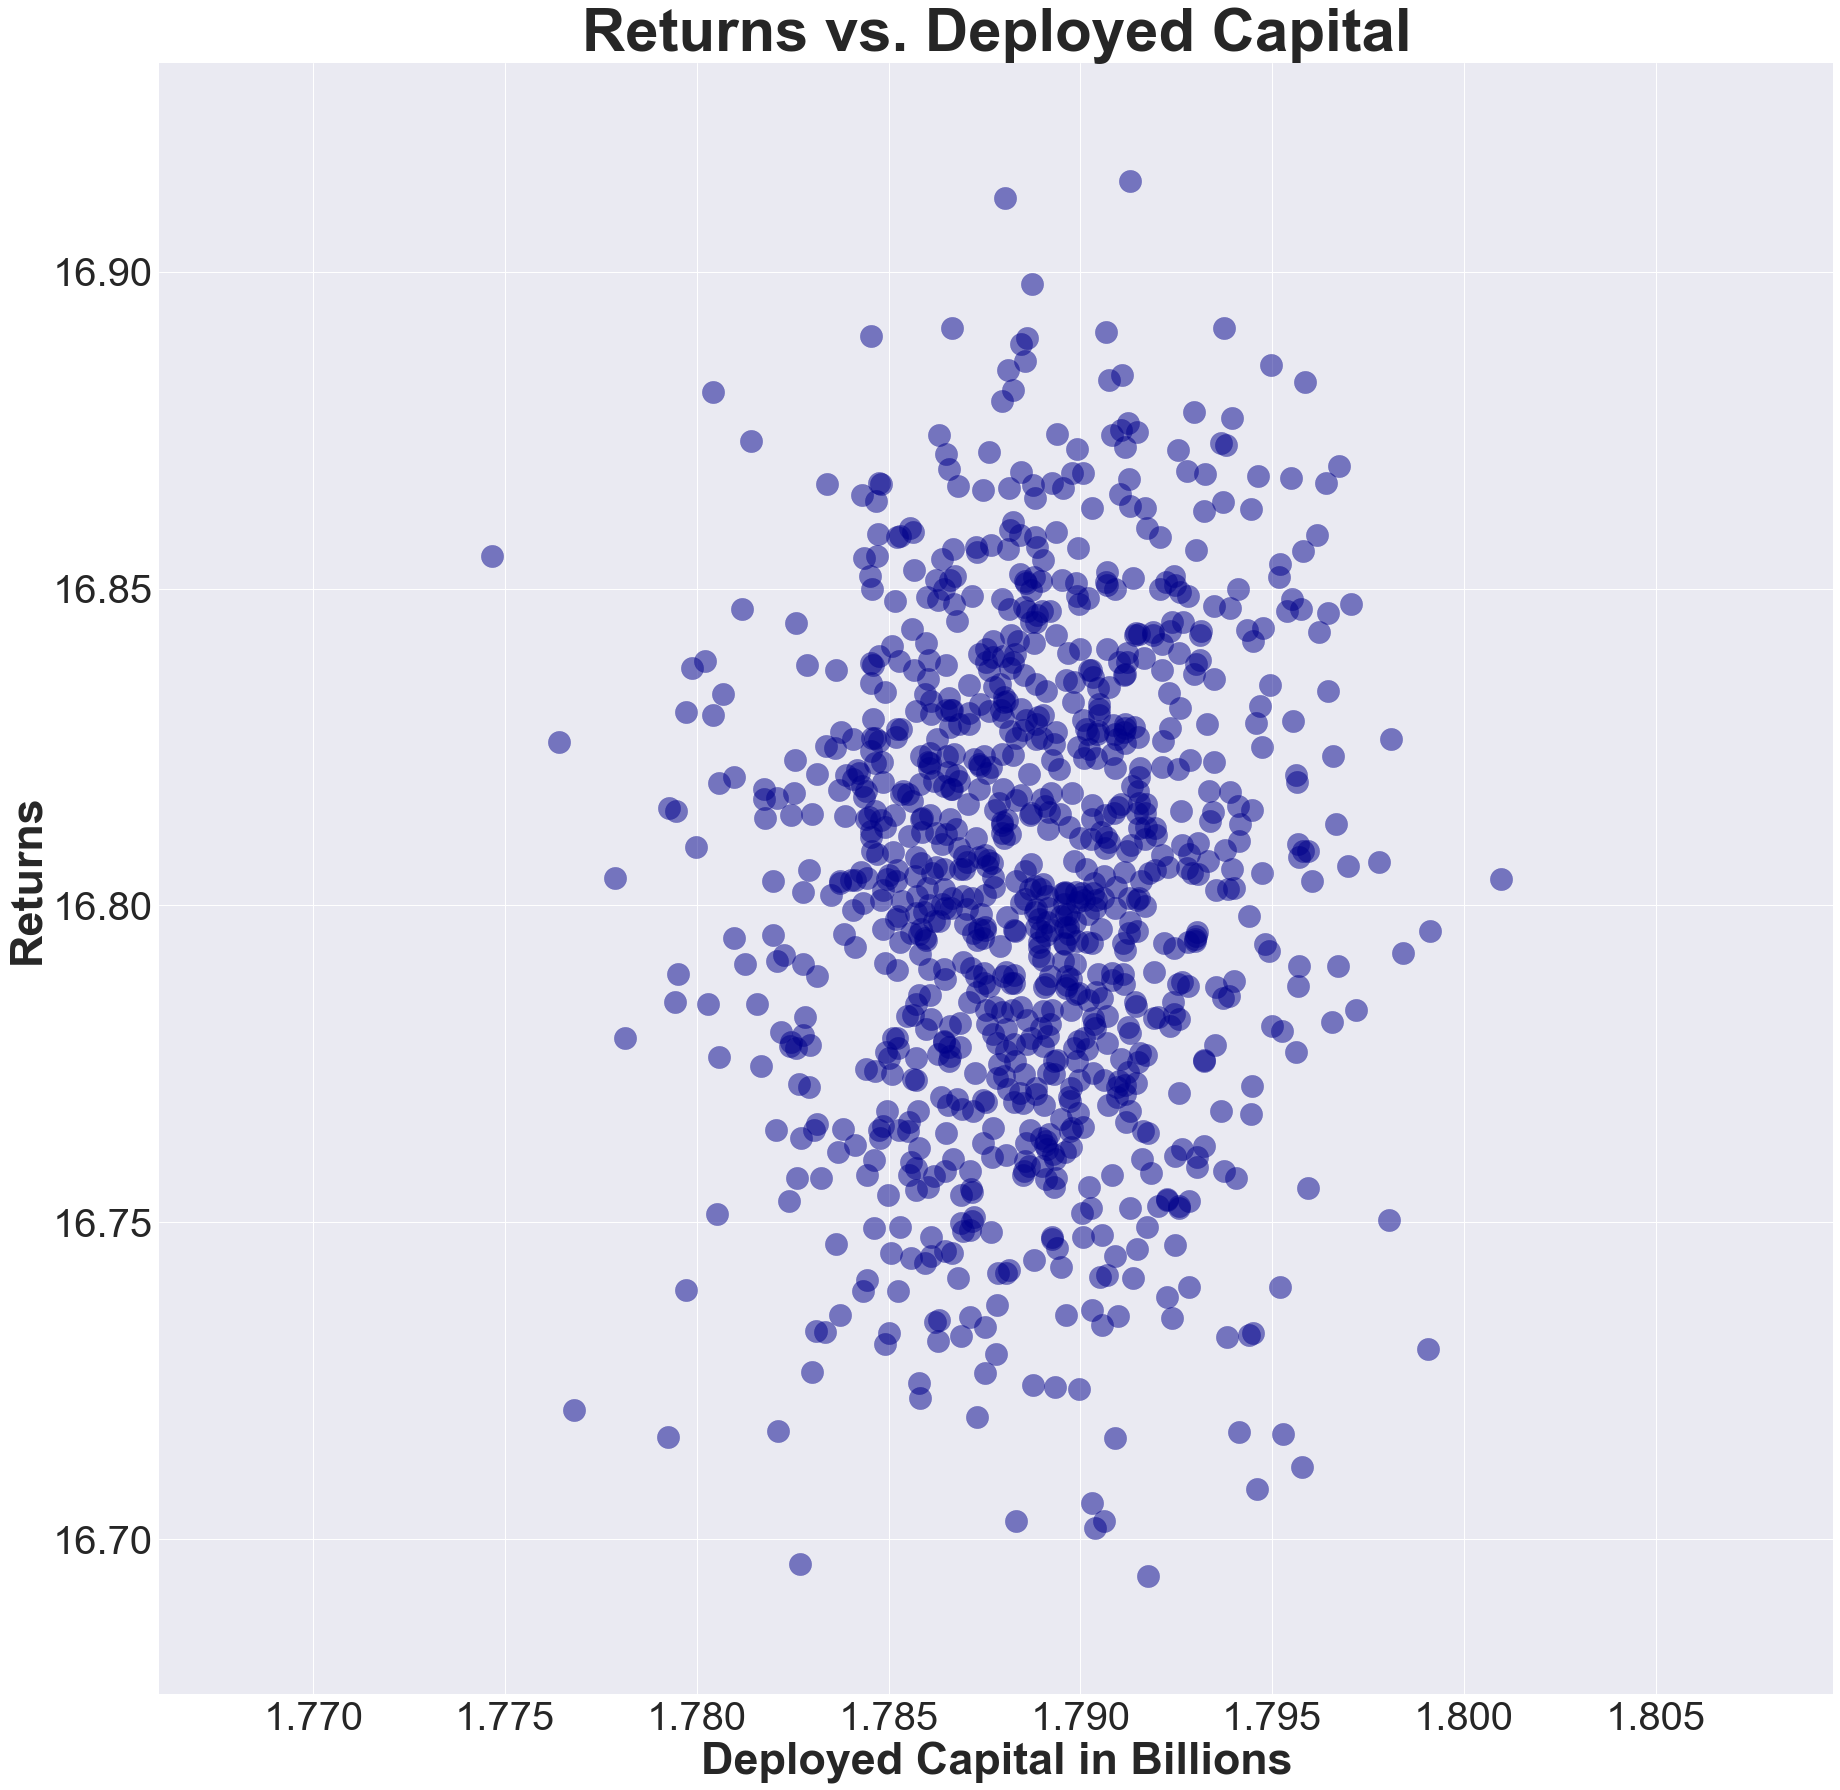

In [49]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(1,1,1)
ax.scatter(np.array(deployed) / 1000000000,rets,c='darkblue',s=500,alpha=0.5)
plt.title('Returns vs. Deployed Capital',fontsize=60,fontweight='bold')
plt.xlabel('Deployed Capital in Billions',fontsize=45,fontweight='bold')
plt.ylabel('Returns',fontsize=45,fontweight='bold')
ax.tick_params('x',labelsize=40)
ax.tick_params('y',labelsize=40)
plt.savefig('images/system_returns_vs_deployed.png')

In [46]:
system_data.describe()

,System_Returns,System_Returns_36,System_Returns_60,Deployed,Deployed_36,Deployed_60
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,16.803819,13.653464,24.169204,1.788652e+09,1.252798e+09,5.358545e+08
std,0.037701,0.027586,0.099432,3.654362e+06,3.336305e+06,3.081098e+06
min,16.694100,13.575500,23.881200,1.774646e+09,1.241565e+09,5.245656e+08
25%,16.778000,13.633400,24.105075,1.786183e+09,1.250667e+09,5.337106e+08
50%,16.804150,13.653850,24.171300,1.788686e+09,1.252812e+09,5.358416e+08
75%,16.829850,13.672050,24.240250,1.791104e+09,1.255083e+09,5.379736e+08
max,16.914400,13.746800,24.477100,1.800970e+09,1.262299e+09,5.454707e+08


In [48]:
system_data.describe()[['Deployed','Deployed_36','Deployed_60']] / 1000000000

,Deployed,Deployed_36,Deployed_60
count,0.000001,0.000001,0.000001
mean,1.788652,1.252798,0.535855
std,0.003654,0.003336,0.003081
min,1.774647,1.241565,0.524566
25%,1.786183,1.250667,0.533711
50%,1.788686,1.252812,0.535842
75%,1.791104,1.255083,0.537974
max,1.800970,1.262299,0.545471
